# Demand Prediction Model by Using Bidirectional LSTM Model

### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv("../data&resources/store_sharing.csv", parse_dates=['timestamp'], index_col="timestamp")

In [3]:
df

cnt    t1    t2     hum  wind_speed  weather_code  \
timestamp                                                                 
2015-01-04 00:00:00   182 3.000 2.000  93.000       6.000         3.000   
2015-01-04 01:00:00   138 3.000 2.500  93.000       5.000         1.000   
2015-01-04 02:00:00   134 2.500 2.500  96.500       0.000         1.000   
2015-01-04 03:00:00    72 2.000 2.000 100.000       0.000         1.000   
2015-01-04 04:00:00    47 2.000 0.000  93.000       6.500         1.000   
...                   ...   ...   ...     ...         ...           ...   
2017-01-03 19:00:00  1042 5.000 1.000  81.000      19.000         3.000   
2017-01-03 20:00:00   541 5.000 1.000  81.000      21.000         4.000   
2017-01-03 21:00:00   337 5.500 1.500  78.500      24.000         4.000   
2017-01-03 22:00:00   224 5.500 1.500  76.000      23.000         4.000   
2017-01-03 23:00:00   139 5.000 1.000  76.000      22.000         2.000   

                     is_holiday  is_weekend  season  
timestamp                                            
2015-01-04 00:00:00       0.000       1.000   3.000  
2015-01-04 01:00:00       0.000       1.000   3.000  
2015-01-04 02:00:00       0.000       1.000   3.000  
2015-01-04 03:00:00       0.000       1.000   3.000  
2015-01-04 04:00:00       0.000       1.000   3.000  
...                         ...         ...     ...  
2017-01-03 19:00:00       0.000       0.000   3.000  
2017-01-03 20:00:00       0.000       0.000   3.000  
2017-01-03 21:00:00       0.000       0.000   3.000  
2017-01-03 22:00:00       0.000       0.000   3.000  
2017-01-03 23:00:00       0.000       0.000   3.000  

[17414 rows x 9 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


---
---

## Exploratory Data Analysis

In [5]:
df.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [6]:
df.describe().T

count     mean      std    min     25%     50%      75%  \
cnt          17414.000 1143.102 1085.108  0.000 257.000 844.000 1671.750   
t1           17414.000   12.468    5.572 -1.500   8.000  12.500   16.000   
t2           17414.000   11.521    6.615 -6.000   6.000  12.500   16.000   
hum          17414.000   72.325   14.313 20.500  63.000  74.500   83.000   
wind_speed   17414.000   15.913    7.895  0.000  10.000  15.000   20.500   
weather_code 17414.000    2.723    2.341  1.000   1.000   2.000    3.000   
is_holiday   17414.000    0.022    0.147  0.000   0.000   0.000    0.000   
is_weekend   17414.000    0.285    0.452  0.000   0.000   0.000    1.000   
season       17414.000    1.492    1.119  0.000   0.000   1.000    2.000   

                  max  
cnt          7860.000  
t1             34.000  
t2             34.000  
hum           100.000  
wind_speed     56.500  
weather_code   26.000  
is_holiday      1.000  
is_weekend      1.000  
season          3.000

In [7]:
def boxplotit(data,x=3,y=3,drops=[]):
    index = 0
    plt.figure(figsize=(x*6, y*4))
    for feature in df.drop(drops,axis=1).columns:
        index += 1
        plt.subplot(x,y,index)
        sns.boxplot(x=feature, data=df, whis=1.5)

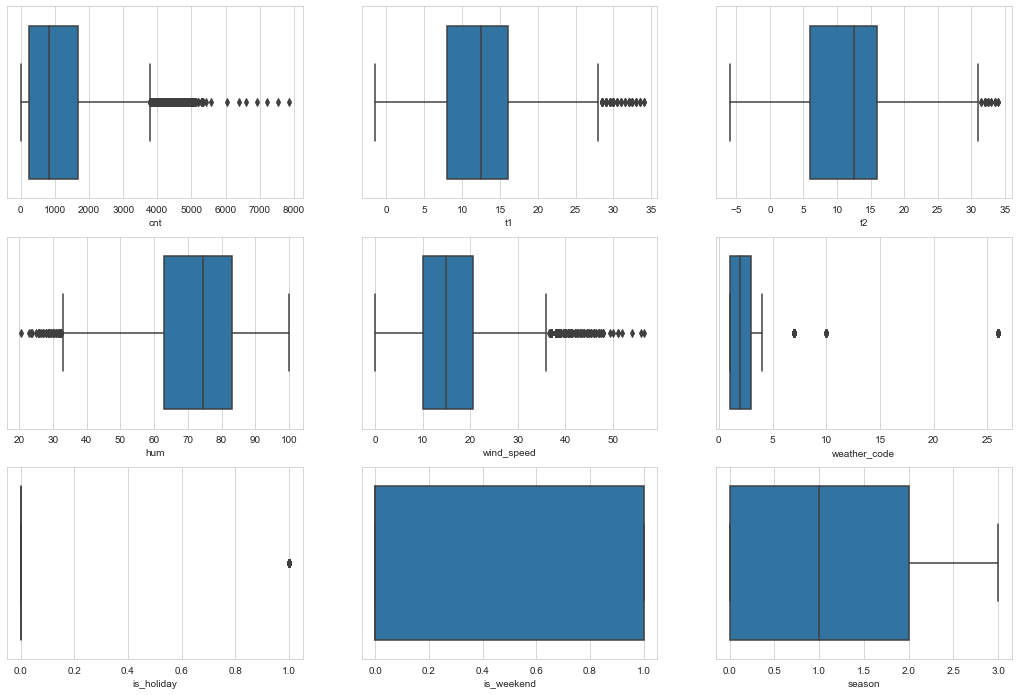

In [8]:
boxplotit(df)

In [9]:
df["year"] = df.index.year
df['month'] = df.index.month 
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour 
df["date"] = df.index.date

In [10]:
df.sample(5)

cnt     t1     t2    hum  wind_speed  weather_code  \
timestamp                                                                  
2016-08-04 15:00:00  1845 22.000 22.000 50.000      26.000         1.000   
2015-10-15 10:00:00  1083 11.000 11.000 72.000      15.000         3.000   
2016-07-26 21:00:00  1419 21.000 21.000 58.500      16.000         2.000   
2016-04-13 01:00:00   103  9.000  8.000 76.000       6.500         1.000   
2016-04-10 08:00:00   348  7.500  5.000 71.000      14.000         1.000   

                     is_holiday  is_weekend  season  year  month  day  \
timestamp                                                               
2016-08-04 15:00:00       0.000       0.000   1.000  2016      8    4   
2015-10-15 10:00:00       0.000       0.000   2.000  2015     10   15   
2016-07-26 21:00:00       0.000       0.000   1.000  2016      7   26   
2016-04-13 01:00:00       0.000       0.000   0.000  2016      4   13   
2016-04-10 08:00:00       0.000       1.000   0.000  2016      4   10   

                     dayofweek  hour        date  
timestamp                                         
2016-08-04 15:00:00          3    15  2016-08-04  
2015-10-15 10:00:00          3    10  2015-10-15  
2016-07-26 21:00:00          1    21  2016-07-26  
2016-04-13 01:00:00          2     1  2016-04-13  
2016-04-10 08:00:00          6     8  2016-04-10

In [11]:
df['season_name'] = df['season'].replace({0:"Spring", 1:"Summer", 2:"Autumn", 3:"Winter"})

In [12]:
df.head()

cnt    t1    t2     hum  wind_speed  weather_code  \
timestamp                                                                
2015-01-04 00:00:00  182 3.000 2.000  93.000       6.000         3.000   
2015-01-04 01:00:00  138 3.000 2.500  93.000       5.000         1.000   
2015-01-04 02:00:00  134 2.500 2.500  96.500       0.000         1.000   
2015-01-04 03:00:00   72 2.000 2.000 100.000       0.000         1.000   
2015-01-04 04:00:00   47 2.000 0.000  93.000       6.500         1.000   

                     is_holiday  is_weekend  season  year  month  day  \
timestamp                                                               
2015-01-04 00:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 01:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 02:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 03:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 04:00:00       0.000       1.000   3.000  2015      1    4   

                     dayofweek  hour        date season_name  
timestamp                                                     
2015-01-04 00:00:00          6     0  2015-01-04      Winter  
2015-01-04 01:00:00          6     1  2015-01-04      Winter  
2015-01-04 02:00:00          6     2  2015-01-04      Winter  
2015-01-04 03:00:00          6     3  2015-01-04      Winter  
2015-01-04 04:00:00          6     4  2015-01-04      Winter

***i. Plot bike shares over time***

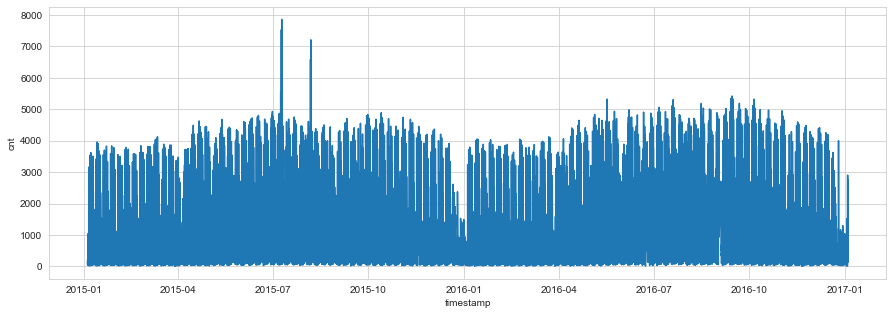

In [13]:
plt.figure(figsize=(15,5))
sns.lineplot(df.index, "cnt", data=df);

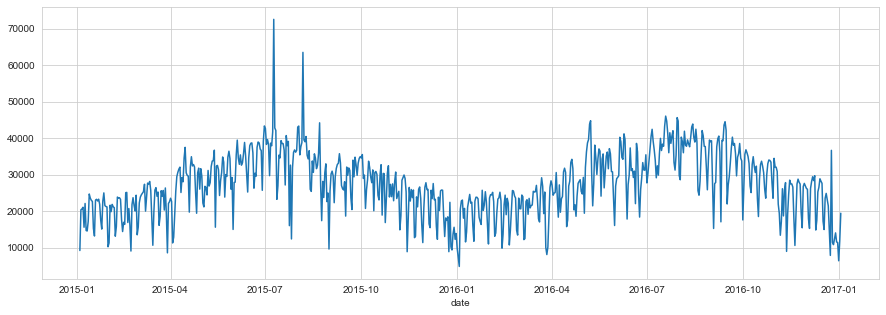

In [14]:
date_cnt = df.groupby("date")["cnt"].sum()
plt.figure(figsize=(15,5))
sns.lineplot(date_cnt.index, date_cnt.values);

***ii. Plot bike shares by months***

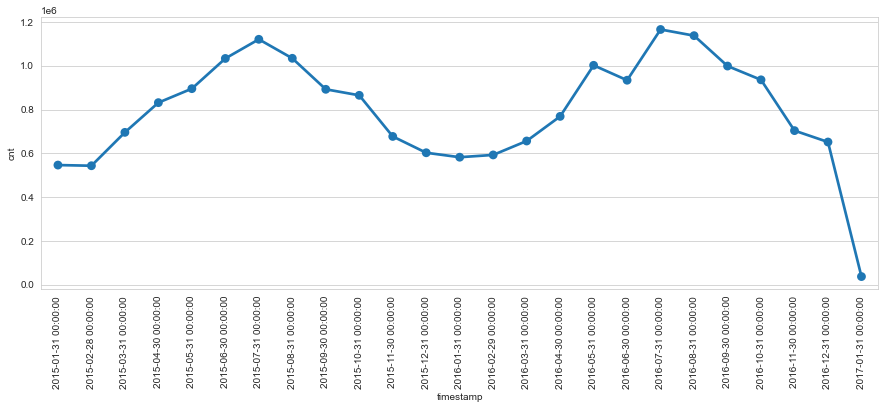

In [15]:
data_by_month = df.resample('M').sum()
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.pointplot(x=data_by_month.index, y=data_by_month.cnt);

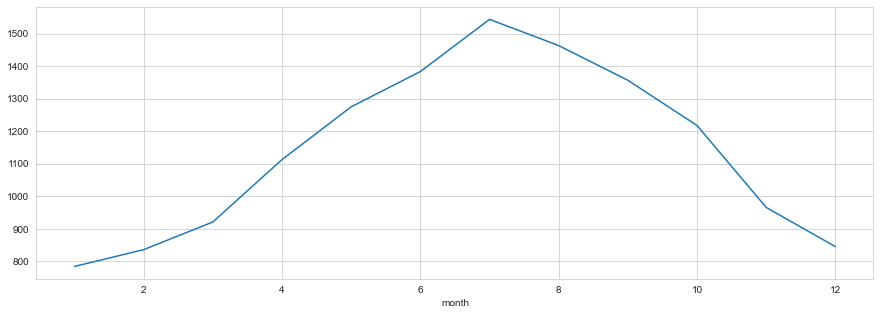

In [16]:
month_cnt = df.groupby("month")["cnt"].mean()
plt.figure(figsize=(15,5))
sns.lineplot(month_cnt.index, month_cnt.values);

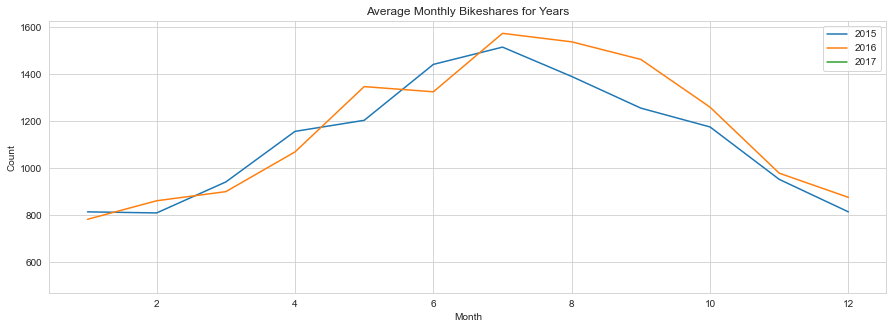

In [17]:
year_month_cnt = df.groupby(["year", "month"])["cnt"].mean()

plt.figure(figsize=(15,5))
for year in year_month_cnt.index.levels[0]:
    plt.plot(year_month_cnt[year].index, year_month_cnt[year],label=year)

plt.legend()
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Average Monthly Bikeshares for Years')
plt.show()

***iii. Plot bike shares by hours***
- *whether it is a holiday or not*
- *You may want to see seasonal breakdowns*

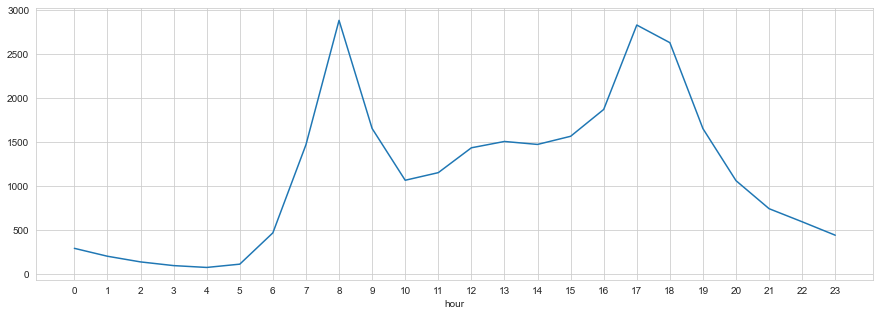

In [18]:
hour_cnt = df.groupby("hour")["cnt"].mean()
plt.figure(figsize=(15,5))
plt.xticks(np.arange(24))
sns.lineplot(hour_cnt.index, hour_cnt.values);

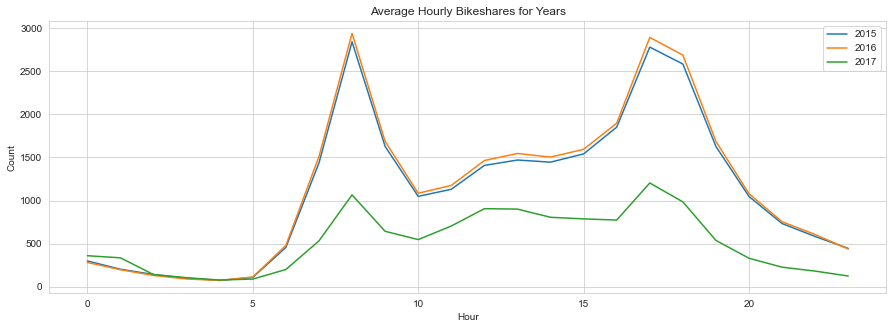

In [19]:
year_hour_cnt = df.groupby(["year", "hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for year in year_month_cnt.index.levels[0]:
    plt.plot(year_hour_cnt[year].index, year_hour_cnt[year],label=year)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Hourly Bikeshares for Years')
plt.show()

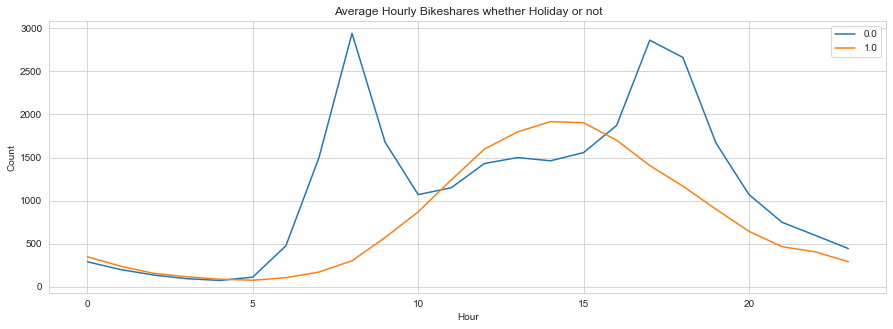

In [20]:
hour_holiday_cnt = df.groupby(["is_holiday","hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for is_holiday in hour_holiday_cnt.index.levels[0]:
    plt.plot(hour_holiday_cnt[is_holiday].index, hour_holiday_cnt[is_holiday], label=is_holiday)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Hourly Bikeshares whether Holiday or not')
plt.show()

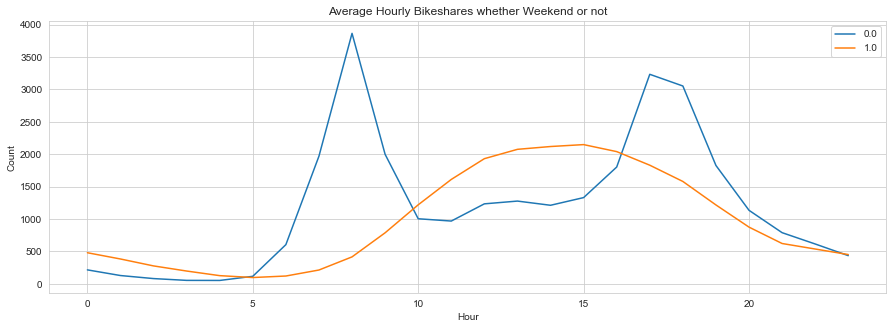

In [21]:
hour_weekend_cnt = df.groupby(["is_weekend","hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for is_weekend in hour_weekend_cnt.index.levels[0]:
    plt.plot(hour_weekend_cnt[is_weekend].index, hour_weekend_cnt[is_weekend], label=is_weekend)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Hourly Bikeshares whether Weekend or not')
plt.show()

In [22]:
df.groupby(["is_holiday","is_weekend"])["cnt"].count()

is_holiday  is_weekend
0.000       0.000         12060
            1.000          4970
1.000       0.000           384
Name: cnt, dtype: int64

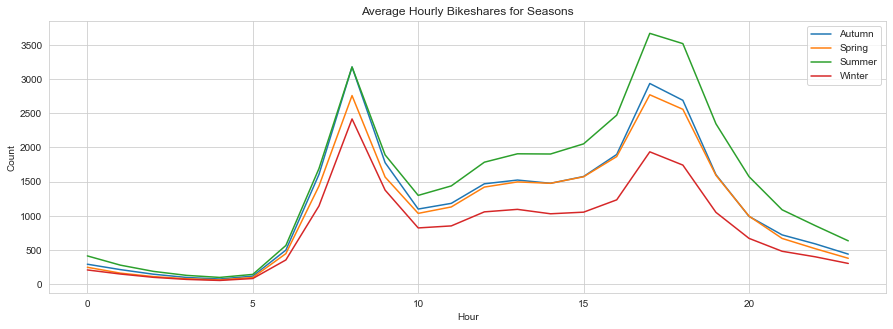

In [23]:
season_hour_cnt = df.groupby(["season_name", "hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for season in season_hour_cnt.index.levels[0]:
    plt.plot(season_hour_cnt[season].index, season_hour_cnt[season],label=season)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Hourly Bikeshares for Seasons')
plt.show()

***iv. Plot bike shares by day of week***
- *You may want to see seasonal breakdowns*

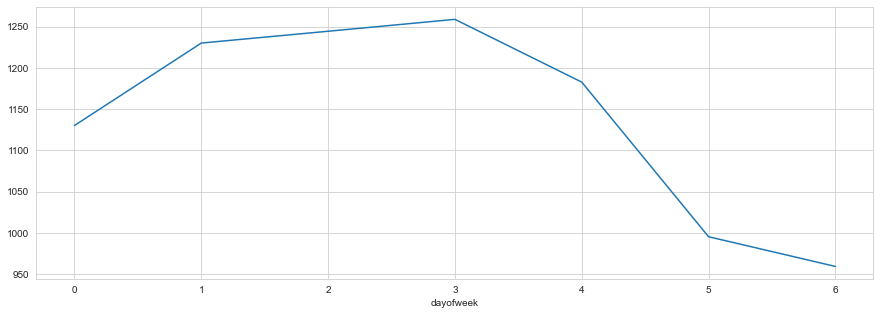

In [24]:
weekday_cnt = df.groupby("dayofweek")["cnt"].mean()
plt.figure(figsize=(15,5))
sns.lineplot(weekday_cnt.index, weekday_cnt.values);

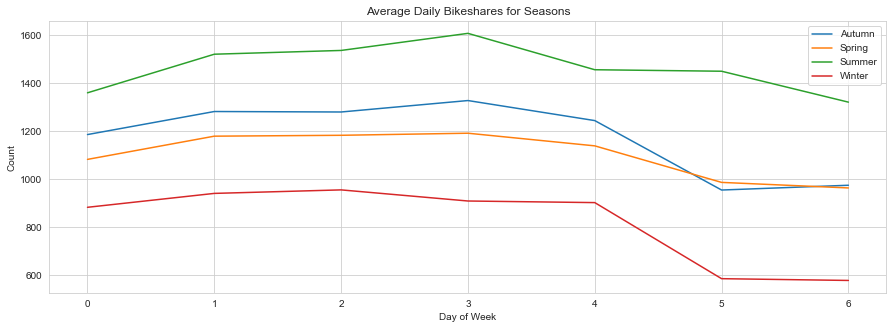

In [25]:
season_dayofweek_cnt = df.groupby(["season_name", "dayofweek"])["cnt"].mean()

plt.figure(figsize=(15,5))
for season in season_dayofweek_cnt.index.levels[0]:
    plt.plot(season_dayofweek_cnt[season].index, season_dayofweek_cnt[season],label=season)

plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.grid(True)
plt.title('Average Daily Bikeshares for Seasons')
plt.show()

***v. Plot the distribution of bike shares on holidays by seasons***

In [26]:
df_holiday=df[df['is_holiday']==1]

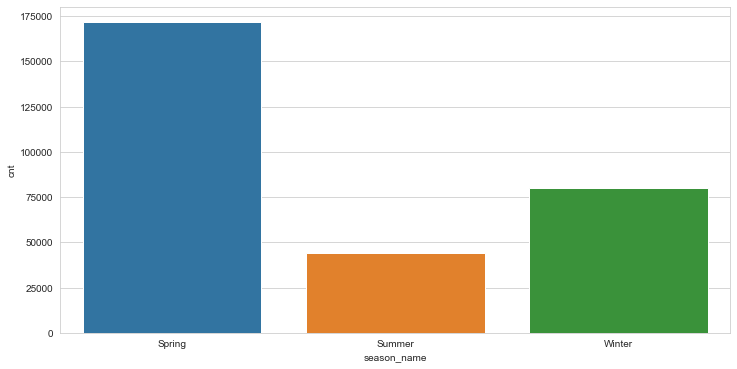

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x='season_name', y='cnt', data=df_holiday, ci=None, estimator=sum);

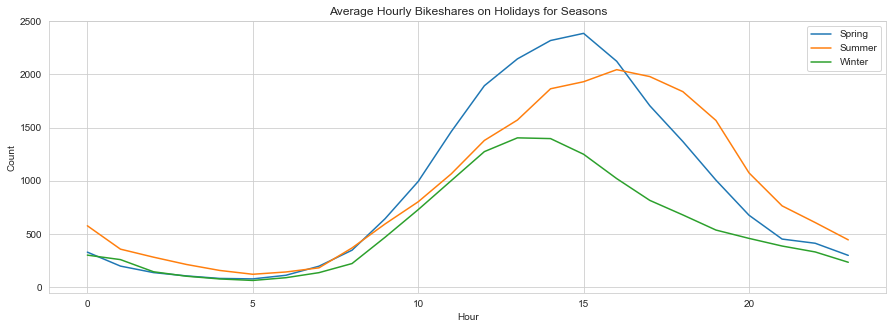

In [28]:
season_holiday_cnt = df_holiday.groupby(["season_name", "hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for season in season_holiday_cnt.index.levels[0]:
    plt.plot(season_holiday_cnt[season].index, season_holiday_cnt[season],label=season)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.grid(True)
plt.title('Average Hourly Bikeshares on Holidays for Seasons')
plt.show()

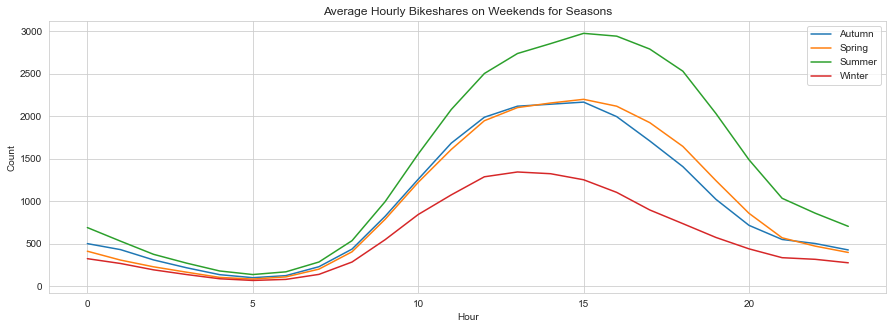

In [29]:
season_weekend_cnt = df[df["is_weekend"]==1].groupby(["season_name", "hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for season in season_weekend_cnt.index.levels[0]:
    plt.plot(season_weekend_cnt[season].index, season_weekend_cnt[season],label=season)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.grid(True)
plt.title('Average Hourly Bikeshares on Weekends for Seasons')
plt.show()

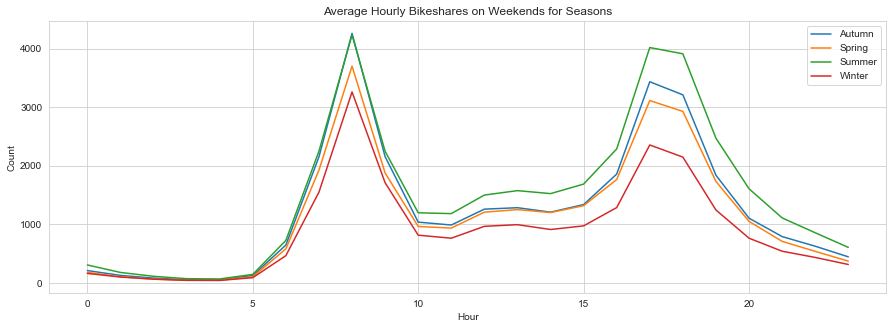

In [30]:
season_weekend_cnt = df[df["is_weekend"]==0].groupby(["season_name", "hour"])["cnt"].mean()

plt.figure(figsize=(15,5))
for season in season_weekend_cnt.index.levels[0]:
    plt.plot(season_weekend_cnt[season].index, season_weekend_cnt[season],label=season)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.grid(True)
plt.title('Average Hourly Bikeshares on Weekends for Seasons')
plt.show()

### Drop unnecessary columns

- Check correlations via heatmap
- Check weather_code
- Think about time-based features and decide dropping which is unnecessary for the model

"weather_code" category description:
- 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
- 2 = scattered clouds / few clouds 
- 3 = Broken clouds 
- 4 = Cloudy 
- 7 = Rain/ light Rain shower/ Light rain 
- 10 = rain with thunderstorm 
- 26 = snowfall 

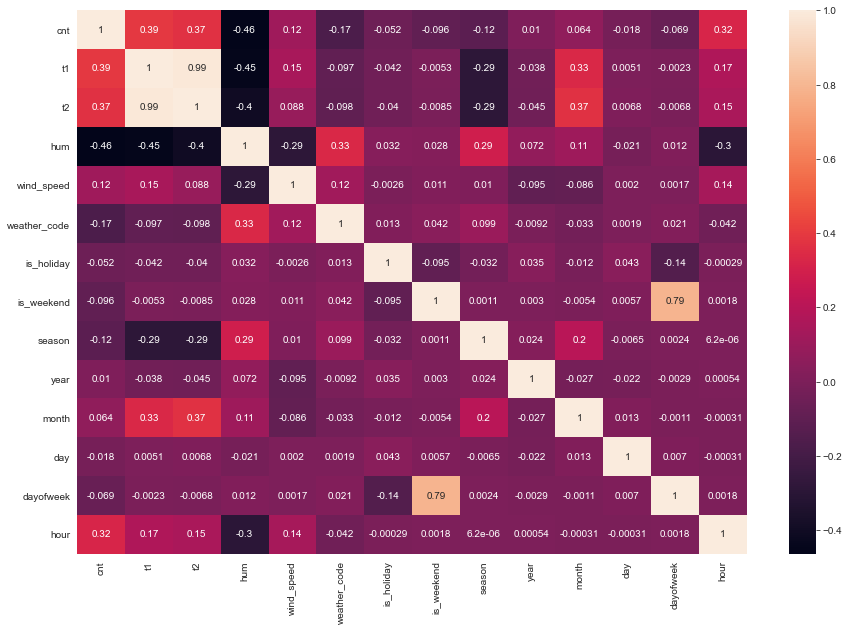

In [31]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True);

In [32]:
df.head()

cnt    t1    t2     hum  wind_speed  weather_code  \
timestamp                                                                
2015-01-04 00:00:00  182 3.000 2.000  93.000       6.000         3.000   
2015-01-04 01:00:00  138 3.000 2.500  93.000       5.000         1.000   
2015-01-04 02:00:00  134 2.500 2.500  96.500       0.000         1.000   
2015-01-04 03:00:00   72 2.000 2.000 100.000       0.000         1.000   
2015-01-04 04:00:00   47 2.000 0.000  93.000       6.500         1.000   

                     is_holiday  is_weekend  season  year  month  day  \
timestamp                                                               
2015-01-04 00:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 01:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 02:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 03:00:00       0.000       1.000   3.000  2015      1    4   
2015-01-04 04:00:00       0.000       1.000   3.000  2015      1    4   

                     dayofweek  hour        date season_name  
timestamp                                                     
2015-01-04 00:00:00          6     0  2015-01-04      Winter  
2015-01-04 01:00:00          6     1  2015-01-04      Winter  
2015-01-04 02:00:00          6     2  2015-01-04      Winter  
2015-01-04 03:00:00          6     3  2015-01-04      Winter  
2015-01-04 04:00:00          6     4  2015-01-04      Winter

weather_code
1.000    1162.089
2.000    1496.177
3.000    1195.124
4.000     635.231
7.000     712.966
10.000    583.429
26.000    250.850
Name: cnt, dtype: float64


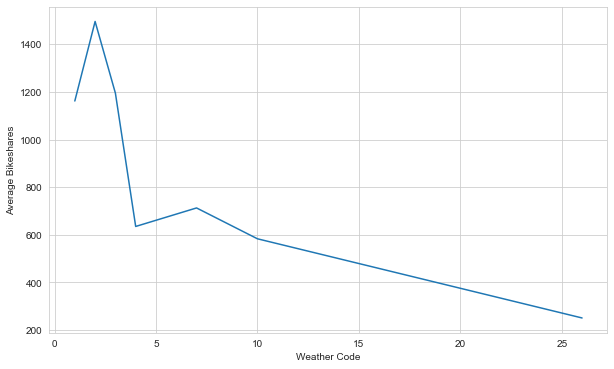

In [33]:
plt.figure(figsize=(10,6))
ax = df.groupby('weather_code')['cnt'].mean().plot()
ax.set(xlabel='Weather Code')
ax.set(ylabel='Average Bikeshares')
print(df.groupby('weather_code')['cnt'].mean())

In [34]:
df_raw = df.drop(["t2", "date", "year", "season_name", "season", "month", "dayofweek", "day", "hour"], axis=1)

In [35]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   hum           17414 non-null  float64
 3   wind_speed    17414 non-null  float64
 4   weather_code  17414 non-null  float64
 5   is_holiday    17414 non-null  float64
 6   is_weekend    17414 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.1 MB


## Data Pre-Processing


In [36]:
weather_dummy = pd.get_dummies(df_raw['weather_code'].astype("str"), prefix="w_code", drop_first=True)
df_dum = pd.concat([df_raw, weather_dummy],axis=1).drop(["weather_code"],axis=1)
df_dum.head()

cnt    t1     hum  wind_speed  is_holiday  is_weekend  \
timestamp                                                                    
2015-01-04 00:00:00  182 3.000  93.000       6.000       0.000       1.000   
2015-01-04 01:00:00  138 3.000  93.000       5.000       0.000       1.000   
2015-01-04 02:00:00  134 2.500  96.500       0.000       0.000       1.000   
2015-01-04 03:00:00   72 2.000 100.000       0.000       0.000       1.000   
2015-01-04 04:00:00   47 2.000  93.000       6.500       0.000       1.000   

                     w_code_10.0  w_code_2.0  w_code_26.0  w_code_3.0  \
timestamp                                                               
2015-01-04 00:00:00            0           0            0           1   
2015-01-04 01:00:00            0           0            0           0   
2015-01-04 02:00:00            0           0            0           0   
2015-01-04 03:00:00            0           0            0           0   
2015-01-04 04:00:00            0           0            0           0   

                     w_code_4.0  w_code_7.0  
timestamp                                    
2015-01-04 00:00:00           0           0  
2015-01-04 01:00:00           0           0  
2015-01-04 02:00:00           0           0  
2015-01-04 03:00:00           0           0  
2015-01-04 04:00:00           0           0

In [37]:
df_dum.shape

(17414, 12)

In [38]:
train_size = int(len(df_dum) * 0.9)
test_size = len(df_dum) - train_size

train, test = df_dum.iloc[0:train_size], df_dum.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [54]:
from sklearn.preprocessing import RobustScaler

In [55]:
f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [56]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) #x = np.asarray(x).astype('float32').

In [57]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15648, 24, 12) (15648,)


##  Model Building with LSTM



##Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






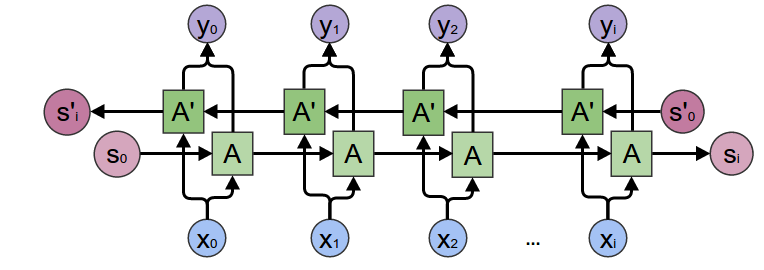

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
X_train.shape

(15648, 24, 12)

In [60]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [61]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [62]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=32, 
          validation_split=0.3,
          shuffle=False,
          callbacks=[early_stop])

Epoch 1/30
343/343 [==============================] - 29s 70ms/step - loss: 0.1468 - val_loss: 0.1017
Epoch 2/30
343/343 [==============================] - 23s 67ms/step - loss: 0.0594 - val_loss: 0.0747
Epoch 3/30
343/343 [==============================] - 20s 59ms/step - loss: 0.0426 - val_loss: 0.0484
Epoch 4/30
343/343 [==============================] - 19s 55ms/step - loss: 0.0336 - val_loss: 0.0499
Epoch 5/30
343/343 [==============================] - 19s 56ms/step - loss: 0.0281 - val_loss: 0.0427
Epoch 6/30
343/343 [==============================] - 19s 55ms/step - loss: 0.0254 - val_loss: 0.0423
Epoch 7/30
343/343 [==============================] - 18s 54ms/step - loss: 0.0229 - val_loss: 0.0381
Epoch 8/30
343/343 [==============================] - 17s 49ms/step - loss: 0.0218 - val_loss: 0.0394
Epoch 9/30
343/343 [==============================] - 14s 42ms/step - loss: 0.0210 - val_loss: 0.0343
Epoch 10/30
343/343 [==============================] - 15s 43ms/step - loss: 0.020

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               144384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 144,641
Trainable params: 144,641
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

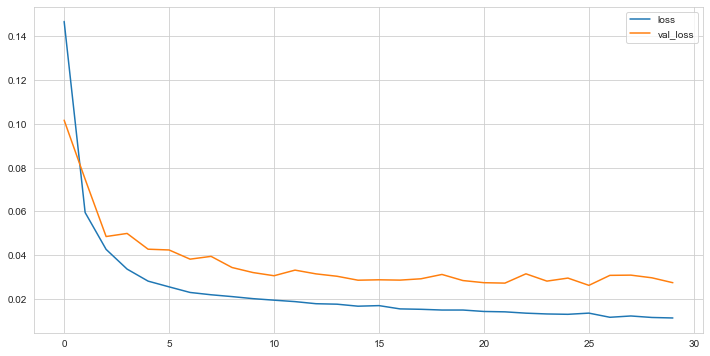

In [64]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

---
---

## Demand Predictions 

In [65]:
y_pred = model.predict(X_test)

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [67]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [68]:
eval_metrics(y_test, y_pred)

r2_score: 0.965409268730402 
 mae: 0.07336147502717312 
 mse: 0.01419126794754605 
 rmse: 0.11912710836558592


### Inverse Transform

In [69]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [70]:
test_index = test.iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index

In [71]:
pred_test

test  prediction
timestamp                               
2016-10-24 08:00:00 3985.000    3970.568
2016-10-24 09:00:00 2070.000    1920.205
2016-10-24 10:00:00  968.000     944.609
2016-10-24 11:00:00  965.000     835.386
2016-10-24 12:00:00 1180.000    1174.187
...                      ...         ...
2017-01-03 19:00:00 1042.000    1227.423
2017-01-03 20:00:00  541.000     677.343
2017-01-03 21:00:00  337.000     415.268
2017-01-03 22:00:00  224.000     243.753
2017-01-03 23:00:00  139.000     140.441

[1718 rows x 2 columns]

In [72]:
eval_metrics(y_test_inv.flatten(), y_pred_inv.flatten())

r2_score: 0.9654092692480241 
 mae: 106.52086032783055 
 mse: 29919.50653116214 
 rmse: 172.97256005263418


### Plot Prediction

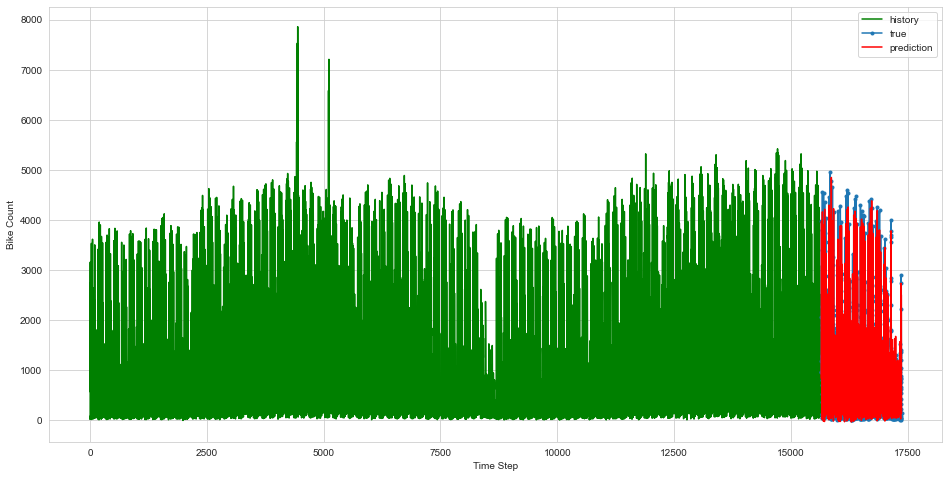

In [73]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

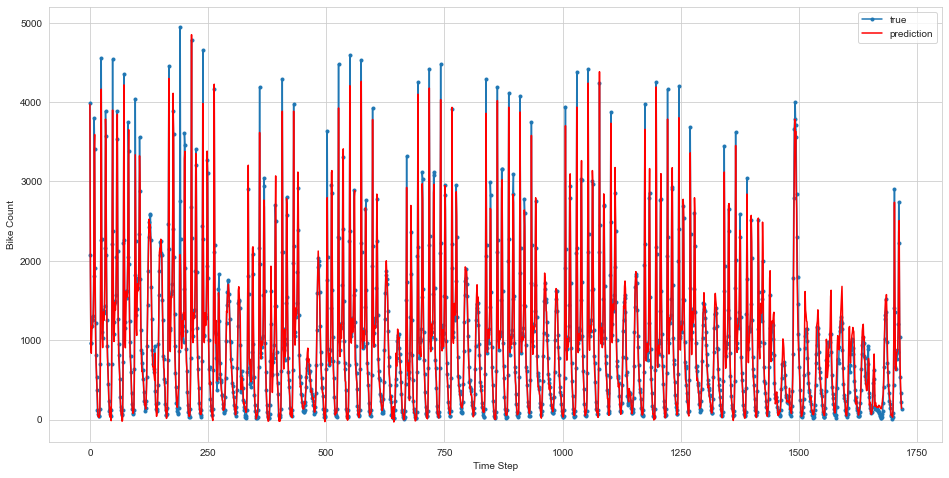

In [74]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

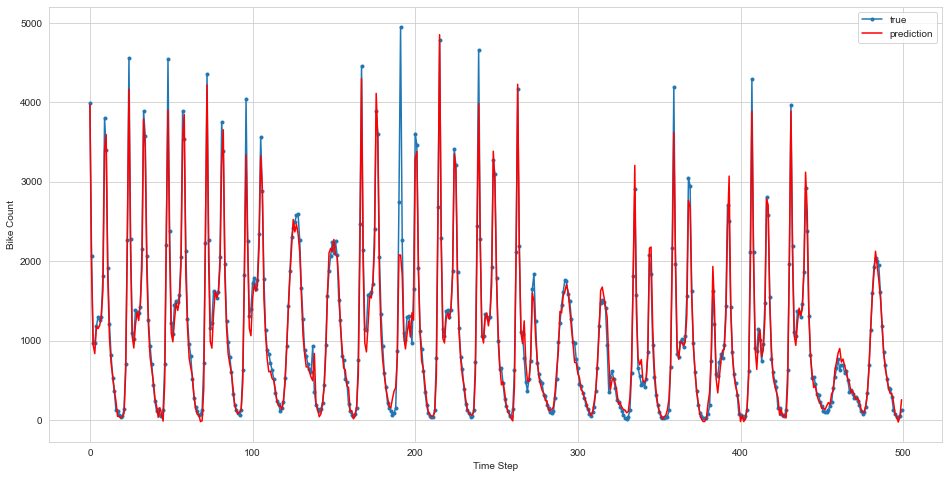

In [75]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten()[0:500], marker='.', label="true")
plt.plot(y_pred_inv.flatten()[0:500], 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

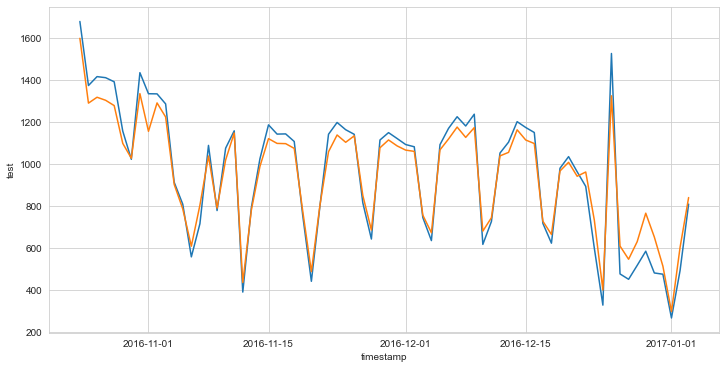

In [76]:
data_by_day = pred_test.resample('24H').mean()
sns.lineplot(x=data_by_day.index, y='test', data=data_by_day)
sns.lineplot(x=data_by_day.index, y='prediction', data=data_by_day)
plt.show()